# Pryngles module: rings

In [29]:
from pryngles import *
sci=Science

## External modules

In [30]:
import spiceypy as spy
import math as mh
import numpy as np
import copy

## Ring default properties

In [31]:
class RingDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Ring'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        (In current version, Ring body does not have orbit attributes)
        
    physics:
    
        fi: float [adimensional], default = 1:
            Fraction of the radius of the primary object where ring stars.
            
        fe: float [adimensional], default = 1:
            Fraction of the radius of the primary object where ring ends.
            
        i: float [radians], default = 0:
            Inclination of the ring with respect to the ecliptic plane.
            
        roll: float [radians], default = 0:
            Roll angle.  This is the angle with respect to ecliptic x-axis in which 
            the normal to the ring plane is rotated.
            
    optics:
    
        nspangles: int, default = 1000: 
            Number of spangles on which the object will be discretized.
            
        albedo_gray_normal: float. default = 1: 
            Lambertian (normal) gray (wavelength indpendent) albedo of the spangle.
            
        tau_gray_optical: float. default = 0:
            Gray (wavelength indpendent) Optical depth of the spangle.  
            If 0 the spangle is entirely opaque to all wavelength, despite its type.            
    """
    orbit=dict()
    
    physics=dict(fi=1.0,fe=2.0,i=0.0,roll=0.0)
    
    optics=dict(nspangles=1000,
                albedo_gray_normal=1,
                tau_gray_optical=0
               )

## Ring Class

In [32]:
BODY_KINDS+=["Ring"]

class Ring(Body):
    """Class Planet.
    
    See Body class documentation.
    
    Additional public attributes:
    
        ri: float [rlu]:
            Radius of the inner border of the ring

        re: float [rlu]:
            Radius of the outer border of the ring
            
        spangles: list of Spangle objects:
            List of spangles covering the surface (for spangle options see Spangle documentation)
    
    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above).
    """
    def __init__(self,
                 primary=None,
                 orbit=RingDefaults.orbit,
                 physics=RingDefaults.physics,
                 optics=RingDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,RingDefaults,"Ring",primary,orbit,physics,optics)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and mandatory for {self.kind}.")
        
        #Update properties
        self.update_body(**self.__dict__)
        
    def _set_transform(self):
        """
        Set transformation matrices
        """
        #Normal vector to ring
        self.nr_ecl=np.array([0,mh.sin(self.physics.i),mh.cos(self.physics.i)]) 
        self.nr_equ=np.array([0,0,1]) 
        
        #Build transformation matrices
        ex_equ=np.array([1,0,0]) 
        ey_equ=np.array([0,mh.cos(self.physics.i),-mh.sin(self.physics.i)])
        ez_equ=self.nr_ecl
        self.M_equ2ecl=np.array(list(np.vstack((ex_equ,ey_equ,ez_equ)).transpose())).reshape((3,3))
        self.M_ecl2equ=spy.invert(self.M_equ2ecl)

In [33]:
if IN_JUPYTER:
    def test_init(self):
        
        #Define first star and planet
        S=Star()
        P=Planet(primary=S)

        self.assertRaises(ValueError,lambda:Ring())
        R=Ring(primary=P)
        
        print(R.physics)
        print(R.optics)
        print(R.hash)
        
    class Test(unittest.TestCase):pass    
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'fi': 1.0, 'fe': 2.0, 'i': 0.0, 'roll': 0.0}
{'nspangles': 1000, 'albedo_gray_normal': 1, 'tau_gray_optical': 0}
8761759067447



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Update body

In [34]:
def update_body(self,**pars):
    Body.update_body(self,**pars)

    #Here place the commands to update this kind of body
    self.ri=self.physics.fi*self.primary.physics.radius
    self.re=self.physics.fe*self.primary.physics.radius

    #Set transformation matrices
    self._set_transform()

Ring.update_body=update_body

In [35]:
if IN_JUPYTER:
    def test_update(self):

        #Define first star and planet
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P)
        
        R.update_body(physics=dict(fe=3))
        print(R.physics)
        
        #Check derived properties
        print(R.M_equ2ecl)
        print(R.M_ecl2equ)
        print(R.nr_ecl)
        print(R.nr_equ)
        
    class Test(unittest.TestCase):pass    
    Test.test_update=test_update
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'fi': 1.0, 'fe': 3, 'i': 0.0, 'roll': 0.0}
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [-0.  0.  1.]]
[0. 0. 1.]
[0 0 1]



----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### Spangle body

This method creates the spangles taht will cover the body.

In [36]:
def spangle_body(self,seed=0):
    
    #Create spangler
    self.sp=Sampler(N=self.optics.nspangles,seed=seed)
    
    #Limits of the ring (normalized to re)
    uri=self.ri/self.re
    ure=1
    
    #Generate spangles
    self.sp.gen_ring([
        [0.0,uri],#Internal gap
    ],boundary=0)
    
    #Purge to avoid close-in spangles
    self.sp.purge_sample()
    self.optics.nspangles=self.sp.N
    
    #Create a spangling
    self.sg=Spangler(nspangles=self.optics.nspangles,body_hash=self.hash)
    #Misc.print_html(self.sg.data.to_html())
    
    #Common
    self.sg.data["type"]=GRANULAR_SPANGLE
    self.sg.data["albedo_gray_normal"]=self.optics.albedo_gray_normal
    self.sg.data["tau_gray_optical"]=self.optics.tau_gray_optical
    self.sg.data["asp"]=self.sp.aes*self.re**2
    
    #Equatorial cartesian coordinates
    xyz_equ=np.hstack((self.sp.ss,np.zeros((self.sp.N,1))))
    xyz_equ*=self.re
    self.sg.data[["x_equ","y_equ","z_equ"]]=xyz_equ
    self.sg.data["ns_equ"]=[[0,0,1]]*self.sg.nspangles
    
    #Ecliptic cartesian coordinates
    self.sg.data[["x_ecl","y_ecl","z_ecl"]]=\
    self.sg.data.apply(lambda df:pd.Series(spy.mxv(self.M_equ2ecl,[df.x_equ,df.y_equ,df.z_equ])),axis=1)
    self.sg.data["ns_ecl"]=[spy.mxv(self.M_equ2ecl,[0,0,1])]*self.sg.nspangles

    #Equatorial spherical coordinates
    rtf_equ=np.hstack((self.sp.pp,np.zeros((self.sp.N,1))))
    rtf_equ[:,0]*=self.re
    self.sg.data[["r_equ","t_equ","f_equ"]]=rtf_equ
    
    #Ecliptic spherical coordinates
    self.sg.data[["r_ecl","t_ecl","f_ecl"]]=\
    self.sg.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_ecl,df.y_ecl,df.z_ecl])),axis=1)
   
Ring.spangle_body=spangle_body

117
{'nspangles': 117, 'albedo_gray_normal': 0.5, 'tau_gray_optical': 0.2}


,body_hash,type,x_equ,y_equ,z_equ,x_ecl,y_ecl,z_ecl,x_obs,y_obs,z_obs,r_equ,t_equ,f_equ,r_ecl,t_ecl,f_ecl,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,8761759117355,1,0.017950,1.007847,0.0,0.017950,1.007847,0.0,0,0,0,1.008007,1.552988,0.0,1.008007,1.552988,0.0,0,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0, 0, 1]",0.080554,0.5,0.2,1,0,0,0,0,0,0
1,8761759117355,1,-0.702757,-0.740225,0.0,-0.702757,-0.740225,0.0,0,0,0,1.020686,3.952951,0.0,1.020686,3.952951,0.0,0,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0, 0, 1]",0.080554,0.5,0.2,1,0,0,0,0,0,0
2,8761759117355,1,1.030700,0.071986,0.0,1.030700,0.071986,0.0,0,0,0,1.033211,0.069729,0.0,1.033211,0.069729,0.0,0,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0, 0, 1]",0.080554,0.5,0.2,1,0,0,0,0,0,0
3,8761759117355,1,-0.818316,0.650850,0.0,-0.818316,0.650850,0.0,0,0,0,1.045585,2.469692,0.0,1.045585,2.469692,0.0,0,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0, 0, 1]",0.080554,0.5,0.2,1,0,0,0,0,0,0
4,8761759117355,1,0.165674,-1.044760,0.0,0.165674,-1.044760,0.0,0,0,0,1.057814,4.869655,0.0,1.057814,4.869655,0.0,0,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0, 0, 1]",0.080554,0.5,0.2,1,0,0,0,0,0,0


<IPython.core.display.Javascript object>


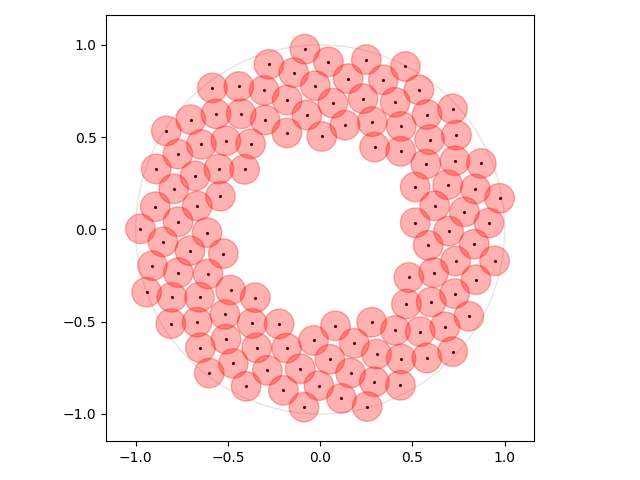

.

0.020138414446088417



----------------------------------------------------------------------
Ran 1 test in 0.124s

OK


In [37]:
if IN_JUPYTER:
    def test_spangler(self):
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P,optics=dict(albedo_gray_normal=0.5,tau_gray_optical=0.2,nspangles=100))  
        R.spangle_body()
        print(R.sp.N)
        print(R.optics)
        
        Misc.print_df(R.sg.data.head(5))
        
        spangled=None
        spangled=dict(color='r')
        R.sp.plot(spangled=spangled)
        #"""
        #print(len(R.spangles))
        print(R.sp.aes)
        
    class Test(unittest.TestCase):pass    
    Test.test_spangler=test_spangler
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [38]:
#Trasnform from observer to other system
"""
    self.eobs_ecl=eobs_ecl
    self.nobs_ecl=spy.latrec(1,self.eobs_ecl[0],self.eobs_ecl[1])
    self.nobs_equ=spy.mxv(self.M_ecl2equ,self.nobs_ecl)
    self.eobs_equ=np.array(Util.transformRecLat(self.nobs_equ))
    #Build transformation matrices
    self.M_ecl2obs=spy.mxm(
        spy.rotate(+(mh.pi/2-self.eobs_ecl[1]),1),
        spy.rotate(np.mod(self.eobs_ecl[0]+np.pi/2,2*mh.pi),3)
    )
    self.M_obs2ecl=spy.invert(self.M_ecl2obs)
    #Observer<->Equatorial
    self.M_equ2obs=spy.mxm(self.M_ecl2obs,self.M_equ2ecl)
    self.M_obs2equ=spy.invert(self.M_equ2obs)
""";

In [39]:
def plot_body(self,
              observer=(1.0,0*Consts.deg,90*Consts.deg),
              source=(1.0,0*Consts.deg,0*Consts.deg)):
    """
    Plot spangle positions from the vantage point of an observer located at (lamb_obs,beta_obs)
    in the ecliptic reference frame.
    
    Parameters:
    
        observer: array (3) [ul, rad, rad], default = (1,0 deg, 90 deg):
            Ecliptic coordinates of the observer (lambda, beta) or longitud and latitude.
            beta = 90 deg sets the observer above the plane of the ecliptic.
            The distance to the observer is in the present version irrelevant.
            
        source: array (3) [ul, rad, rad], default = (1,0 deg,0 deg):
            Location of the source of light for test purposes.
            
    """

    #Prepare plotting area
    fig,ax=plt.subplots(1,figsize=(5,5))
    fig.patch.set_facecolor("black")
    
    #Prepare Spangling
    
    
    #Scatter plot 
    ax.scatter(self.sg.data.x_equ,self.sg.data.y_equ,c='w',s=2,marker='o')
    
    ax.axis("off")

Ring.plot_body=plot_body

<IPython.core.display.Javascript object>


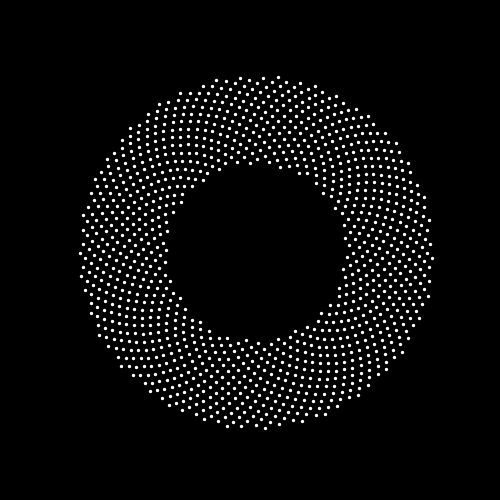

.
----------------------------------------------------------------------
Ran 1 test in 0.363s

OK


In [40]:
if IN_JUPYTER:
    def test_plot(self):
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P,optics=dict(nspangles=1000))  
        R.spangle_body()
        R.plot_body()
        
    class Test(unittest.TestCase):pass    
    Test.test_plot=test_plot
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [41]:
def calculate_flux(self,
                   df,
                   observer=(1.0,0*Consts.deg,90*Consts.deg),
                   source=(1.0,0*Consts.deg,0*Consts.deg)
                  ):
    """
    Calculate the flux scattered from the spangles of the body.
    
    Parameters:
    
        observer: array (3) [ul, rad, rad], default = (1,0 deg, 90 deg):
            Ecliptic coordinates of the observer (lambda, beta) or longitud and latitude.
            beta = 90 deg sets the observer above the plane of the ecliptic.
            The distance to the observer is in the present version irrelevant.
            
        source: array (3) [ul, rad, rad], default = (1,0 deg,0 deg):
            Location of the source of light for test purposes.

    Return:
        
        
    """
    pass

--End--